# Определение перспективного тарифа для телеком компании

## Постановка задачи
Компания «Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. Имеются данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Описание тарифов

#### Тариф «Смарт»
* Ежемесячная плата: 550 рублей
* Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
  * минута разговора: 3 рубля
  * сообщение: 3 рубля
  * 1 Гб интернет-трафика: 200 рублей

#### Тариф «Ультра»
* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
  * минута разговора: 1 рубль
  * сообщение: 1 рубль
  * 1 Гб интернет-трафика: 150 рублей

Обратите внимание: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

### Описание данных

* Таблица users (информация о пользователях)
* Таблица calls (информация о звонках)
* Таблица messages (информация о сообщениях)
* Таблица internet (информация об интернет-сессиях)
* Таблица tariffs (информация о тарифах)

## Шаг 1. Открываем и изучаем данные

Импортируем библиотеку pandas для работы с данными.

In [1]:
import pandas as pd

### Пользователи 

Откроем файл с информацией о пользователях. Просмотрим первые 10 строк файла и общую информацию о нем.

In [2]:
users = pd.read_csv('datasets/users.csv')

In [3]:
users.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Видим, что в выгрузке возраст пользователя вместо даты рождения. Предположим, что дата рождения все же известна, но для нашей выборки был рассчитан и выгружен только возраст.

Из 500 клиентов 38 прератили пользоваться своим тарифом.

Даты выгружены как строковые объекты - нам потребуется преобразовать их к формату datetime.

### Звонки 

Откроем и изучим файл с инфомацией о звонках.

In [5]:
calls = pd.read_csv('/datasets/calls.csv')

In [6]:
calls.head(10)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


In [7]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Похоже, id звонка содержит в себе еще и id пользвователя.

Дату также потребуется привести к формату datetime.

Звонки продолжительностью 0.0 мин пока загадка, впоследствии займемся и ими тоже.

### Сообщения 

Откроем и изучим файл с информацией о сообщениях.

In [8]:
messages = pd.read_csv('/datasets/messages.csv')

In [9]:
messages.head(10)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


In [10]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Похоже, что id сообщений хранятся в том же формате, как и id звонков - содержат в себе id пользователя.

Дата и здесь выгружена как строка, позже переведем ее к подходящему для работы формату.

### Интернет 

Откроем и изучим файл с информацией об интернет-сессиях.

In [11]:
internet = pd.read_csv('/datasets/internet.csv')

In [12]:
internet.head(10)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
5,1000_5,399.97,2018-10-02,1000
6,1000_6,540.08,2018-09-07,1000
7,1000_7,415.70,2018-07-11,1000
8,1000_8,505.40,2018-10-08,1000
9,1000_9,345.54,2018-09-03,1000


In [13]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


Видим примерно похожую на остальные таблицы ситуацию.

Id сессии выгружен по тому же типу, что и в предыдущих случаях. 

Дату потребуется перевести в подходящий для работы формат.

### Тарифы 

Откроем и изучим файл с информацией и о тарифах.

In [14]:
tariffs = pd.read_csv('/datasets/tariffs.csv')

In [15]:
tariffs

,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Здесь в удобном виде представлено уже известное нам описание тарифов.

### Вывод

Были открыты и изучены файлы с необходимой для работы информацией: о пользователях, о звонках, о сообщениях, об интернет-сессиях, о самих тарифах.

В данных есть проблемы: формат дат и звонки продолжительностью 0.0 минут. Потребуется предобработка.

## Шаг 2. Готовим данные

### Формат 

Приведем все даты в наших таблицах к формату datetime, с которым удобно работать методами pandas.

В столбце с датой окончания пользования тарфиом есть пропуски. Для них добавим обработку ошибок.

In [16]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d', errors='coerce')

In [17]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

In [18]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

In [19]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

In [20]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

Проверим на примере таблицы с пользователями.

In [21]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [22]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


Видим, что даты преобразованы. Пропуски получили значение NaT - "Not A Time".

### Нулевые звонки

Посмотрим, сколько звонков имеют нулевую продолжительность. Посчитаем долю в процентах и общее количество.

In [23]:
calls.query('duration == 0')['duration'].count() * 100 / len(calls)

19.551644316336553

In [24]:
calls.query('duration == 0')['duration'].count()

39613

Почти 20% - это слишком много для, например, сброшенных звонков. Известно, что звонки продолжительностью до 3 секунд не должны тарифициоваться. Проверим, есть ли в данных звонки меньше 3 с.

In [25]:
calls.query('duration < 3')['duration'].count()

67460

Есть, и их значительно больше, чем звонков с нулевой продолжительностью.

Проверим, у всех ли пользователей есть такие нулевые звонки.

In [26]:
len(calls.query('duration == 0')['user_id'].unique())

492

In [27]:
len(calls['user_id'].unique())

492

У всех. Интересно, что 8 пользователей вообще не совершали звонки. Но мы не об этом.

Может быть, нулевые звонки - это ошибка с выгрузкой одного из тарифов? Для того, чтобы это проверить, нам нужно соединить таблицу с пользователями (там информация о тарифе) с таблицей звонков.

In [28]:
users_calls = users.join(calls.set_index('user_id'), on='user_id')

In [29]:
users_calls.query('duration == 0')['tariff'].value_counts()

smart    25669
ultra    13944
Name: tariff, dtype: int64

In [30]:
users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

Нулевые звонки есть на обоих тарифах. На тарифе «Смарт» их больше, но пропорционально количеству пользователей тарифа.

Итак, у нас не получается найти закономерность для возникновения нулевых звонков. В текущем виде они не дадут нам информации для расчетов, поэтому удалим эти значения как аномальные несмотря на большой процент относительно выборки.

In [31]:
calls = calls.drop(calls[calls['duration'] == 0].index)

In [32]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162994 entries, 2 to 202606
Data columns (total 4 columns):
id           162994 non-null object
call_date    162994 non-null datetime64[ns]
duration     162994 non-null float64
user_id      162994 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


Удалили порядка 20% данных о звонках, убрав тем самым аномалии.

### Расчет дополнительных данных

Посчитаем для каждого пользователя:
* количество сделанных звонков по месяцам
* количество израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя.

Для расчетов нам понадобится месяц для каждого события. Добавим его в исходные таблицы со звонками, сообщениями и интернет-сессиями.

In [33]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month

In [34]:
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

In [35]:
internet['month'] = pd.DatetimeIndex(internet['session_date']).month

Для звонков и интернета добавим округленные значения. Чтобы округлить в большую сторону, воспользуемся библиотекой numpy.

In [36]:
import numpy as np

In [37]:
calls['duration_rounded'] = calls['duration'].apply(np.ceil)

In [38]:
internet['mb_used_rounded'] = internet['mb_used'].apply(np.ceil)

Соберем сводные таблицы по звонкам, сообщениям и интернет-трафику для каждого пользователя помесячно.

In [39]:
calls_by_month = calls.pivot_table(
    index=['user_id', 'month'], 
    values='duration_rounded', 
    aggfunc=['count', 'sum'])

In [40]:
messages_by_month = messages.pivot_table(
    index=['user_id', 'month'], 
    values='id', 
    aggfunc='count')

In [41]:
internet_by_month = internet.pivot_table(
    index=['user_id', 'month'], 
    values='mb_used_rounded', 
    aggfunc='sum')

Объединим сводные таблицы в одну.

In [42]:
revenue = pd.concat([calls_by_month, messages_by_month, internet_by_month], axis=1)

In [43]:
revenue = revenue.reset_index()

In [44]:
revenue.head()

,user_id,month,"(count, duration_rounded)","(sum, duration_rounded)",id,mb_used_rounded
0,1000,5,17.0,159.0,22.0,2256.0
1,1000,6,28.0,172.0,60.0,23257.0
2,1000,7,41.0,340.0,75.0,14016.0
3,1000,8,42.0,408.0,81.0,14070.0
4,1000,9,46.0,466.0,57.0,14581.0


Переименуем столбцы для удобства работы.

In [45]:
revenue.set_axis(['user_id', 'month','calls', 'minutes', 'messages', 'mb_used'], axis='columns', inplace=True)

In [46]:
revenue.head()

,user_id,month,calls,minutes,messages,mb_used
0,1000,5,17.0,159.0,22.0,2256.0
1,1000,6,28.0,172.0,60.0,23257.0
2,1000,7,41.0,340.0,75.0,14016.0
3,1000,8,42.0,408.0,81.0,14070.0
4,1000,9,46.0,466.0,57.0,14581.0


Получили таблицу с тратами каждого пользователя по месяцам, хотя назвали ее прибылью.

#### Помесячная выручка с каждого пользователя

Теперь рассчитаем выручку. Для этого:
* вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; 
* остаток умножим на значение тарифного плана; 
* прибавим абонентскую плату, соответствующую тарифному плану.

Нам стоит добавить информацию о тарифе в рабочую таблицу. Название тарифа возьмем из таблицы users.

In [47]:
revenue = revenue.merge(users.loc[:, ['user_id', 'tariff']], on='user_id', how='right')

Переименуем столбец с тарифом, чтобы получить возможность присоединить к таблице данные по тарифам.

In [48]:
revenue.set_axis(['user_id', 'month','calls', 'minutes', 'messages', 'mb_used', 'tariff_name'], axis='columns', inplace=True)

Теперь добавим информацию о тарифах.

In [49]:
revenue = revenue.merge(tariffs, on='tariff_name')

Теперь есть все, чтобы рассчитать выручку.

Посчитаем, сколько пользователи заплатили за минуты, потраченные сверх тарифного лимита.

In [50]:
def calls_revenue_calc(row):
    spent = row['minutes']
    included = row['minutes_included']
    beyond_limit = row['rub_per_minute']
    diff = spent - included
    if diff <= 0:
        return 0
    else:
        return diff * beyond_limit

In [51]:
revenue['calls_revenue'] = revenue.apply(calls_revenue_calc, axis=1)

Посчитаем, сколько заплатили за смс сверх лимита.

In [52]:
def messages_revenue_calc(row):
    spent = row['messages']
    included = row['messages_included']
    beyond_limit = row['rub_per_message']
    diff = spent - included
    if diff <= 0:
        return 0
    else:
        return diff * beyond_limit

In [53]:
revenue['messages_revenue'] = revenue.apply(messages_revenue_calc, axis=1)

Посчитаем, сколько пользователи заплатили за интернет сверх включенного в тариф лимита. 

In [54]:
def internet_revenue_calc(row):
    spent = row['mb_used']
    included = row['mg_per_month_included']
    beyond_limit = row['rub_per_gb']
    diff = spent - included
    if diff <= 0:
        return 0
    else:
        return np.ceil(diff / 1024) * beyond_limit

In [55]:
revenue['internet_revenue'] = revenue.apply(internet_revenue_calc, axis=1)

Для корректного рассчета помесячной выручки заменим пустые значения нулями.

In [56]:
revenue = revenue.fillna(0)

Нам осталось просуммировать плату сверх лимитов и абонентскую плату.

In [57]:
revenue['total_revenue'] = revenue['calls_revenue'] + revenue['messages_revenue'] + revenue['internet_revenue'] + revenue['rub_monthly_fee']

In [58]:
revenue.head()

,user_id,month,calls,minutes,messages,mb_used,tariff_name,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,calls_revenue,messages_revenue,internet_revenue,total_revenue
0,1000,5.0,17.0,159.0,22.0,2256.0,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
1,1000,6.0,28.0,172.0,60.0,23257.0,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
2,1000,7.0,41.0,340.0,75.0,14016.0,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
3,1000,8.0,42.0,408.0,81.0,14070.0,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
4,1000,9.0,46.0,466.0,57.0,14581.0,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.0


### Подготовка данных для анализа

Соберем в отдельный датафрейм данные, которые понадобятся нам для анализа.

In [59]:
final_data = pd.DataFrame({'user_id': revenue['user_id'],
                           'month': revenue['month'],
                           'calls': revenue['calls'],
                           'minutes': revenue['minutes'],
                           'messages': revenue['messages'],
                           'mb_used': revenue['mb_used'],
                           'tariff': revenue['tariff_name'],
                           'revenue': revenue['total_revenue']})

In [60]:
final_data = final_data.merge(users.loc[:, ['user_id', 'city']], on='user_id')
final_data

,user_id,month,calls,minutes,messages,mb_used,tariff,revenue,city
0,1000,5.0,17.0,159.0,22.0,2256.0,ultra,1950.0,Краснодар
1,1000,6.0,28.0,172.0,60.0,23257.0,ultra,1950.0,Краснодар
2,1000,7.0,41.0,340.0,75.0,14016.0,ultra,1950.0,Краснодар
3,1000,8.0,42.0,408.0,81.0,14070.0,ultra,1950.0,Краснодар
4,1000,9.0,46.0,466.0,57.0,14581.0,ultra,1950.0,Краснодар
...,...,...,...,...,...,...,...,...,...
3211,1499,9.0,8.0,70.0,11.0,1848.0,smart,550.0,Пермь
3212,1499,10.0,44.0,449.0,48.0,17809.0,smart,1150.0,Пермь
3213,1499,11.0,62.0,612.0,59.0,17984.0,smart,1513.0,Пермь
3214,1499,12.0,56.0,492.0,66.0,13077.0,smart,598.0,Пермь


Данные для анализа подготовлены.

Необходимые параметры рассчитаны.

### Вывод

Был скорректирован формат дат в данных. 

Были вычищены аномальные звонки длительностью 0 секунд, что составило порядка 20% информации о звонках.

Были рассчитаны данные для анализа по каждому пользователю:
* количество сделанных звонков по месяцам
* количество израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячная выручка с каждого пользователя

Был собран датафрейм final_data для дальнейшего анализа.

## Шаг 3. Анализируем данные

Опишем поведение клиентов оператора, исходя из выборки. Для этого посчитаем, сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц; рассмотрим среднее количество, дисперсию и стандартное отклонение. Также построим гистограммы, чтобы оценить распределения.

Рассчитаем статистики по каждому показателю и округлим их до второго знака после запятой для удобства отображения.

In [61]:
call_stats = final_data.pivot_table(index='tariff', values='minutes', aggfunc=['mean', 'var', 'std'])
call_stats = call_stats.round(2)

In [62]:
messages_stats = final_data.pivot_table(index='tariff', values='messages', aggfunc=['mean', 'var', 'std'])
messages_stats = messages_stats.round(2)

In [63]:
internet_stats = final_data.pivot_table(index='tariff', values='mb_used', aggfunc=['mean', 'var', 'std'])
internet_stats = internet_stats.round(2)

Выведем статистики на экран.

In [64]:
call_stats

,mean,var,std
,minutes,minutes,minutes
tariff,,,
smart,417.75,36281.39,190.48
ultra,526.09,101052.49,317.89


In [65]:
messages_stats

,mean,var,std
,messages,messages,messages
tariff,,,
smart,33.37,796.96,28.23
ultra,49.31,2285.42,47.81


In [66]:
internet_stats

,mean,var,std
,mb_used,mb_used,mb_used
tariff,,,
smart,16221.91,3.464852e+07,5886.30
ultra,19467.14,1.022173e+08,10110.26


По всем трем параметрам видим примерно одинаковое соотношение. Пользователи «Ультры» в среднем больше звонят, больше пишут и больше пользуются интернетом. Разброс значений для тарифа «Ультра» значительно шире.

Изучим распределения на гистограммах. Сопоставим тарифы по каждому показателю: минутам разговора, количеству сообщений, объему трафика.

In [67]:
columns = ['minutes', 'messages', 'mb_used']

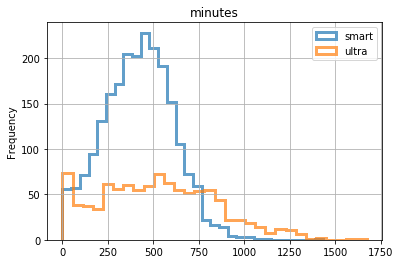

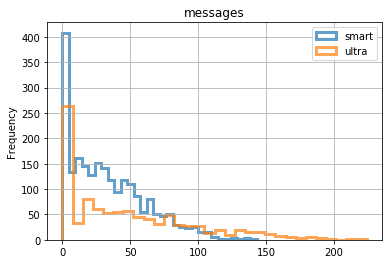

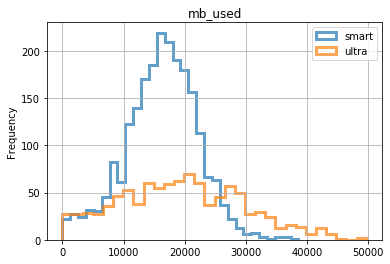

In [69]:
for column_name in columns:
    ax = final_data[final_data['tariff'] == 'smart'].plot(
        kind='hist', y=column_name, histtype='step', linewidth=3, bins=30, alpha=0.7, label='smart')
    final_data[final_data['tariff'] == 'ultra'].plot(
        kind='hist', y=column_name, histtype='step', linewidth=3, bins=30, alpha=0.7, label='ultra', 
        ax=ax, grid=True, legend=True, title=column_name)

В каждом из случаев графики похожи на усеченное нормальное распределение. Значения в области нуля скрее всего отображают тех клиентов, которые не пользуются одной из услуг. Так на графике звонков у тарифа «Ультра» в области нуля пик. Вероятно, это самые активные пользователи интернета, которым нужен больший пакет трафика. Смс-сообщения отходят на второй план по сравнению с интернет-мессенджерами, что видно по большим пикам в области нуля на графике сообщений.

В качестве иллюстрации рассчитанных статистик видим, что для тарифа «Смарт» пик расположен близко к среднему значению, тогда как для тарифа «Ультра» характерен больший разброс значений. Также видим, что для тарифа Ультра чаще встречается большее количество потраченных единиц из пакета услуг.

### Вывод

Были посчитаны описательные статистики для поведения пользователей тарифов «Смарт» и «Ультра». Для тарифа «Смарт» среднее количество минут разговора, отправленных сообщений и использованных мегабайт интернета - вполне характерная величина. Тогда как для тарифа «Ультра» характерен больший разброс этих значений. Также пользователи «Ультры» в среднем больше разговаривают, больше отравляют сообщения и больше пользуются интернетом. Это вполне справедливое следствие того, что пакет услуг в данном тарифе включает в себя больше минут разговора, сообщений и трафика.

## Шаг 4. Проверяем гипотезы

Необходимо проверить следующие гипотезы:
1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

### Средняя выручка тарифов «Ультра» и «Смарт»

Сформируем нулевую гипотезу так, чтобы использовать знак равенства. Это позволит нам воспользоваться статистическим тестом для проверки равенства средних двух генеральных совокупностей. 

Таким образом, нулевая гипотеза H0: средняя выручка тарифов «Ультра» и «Смарт» одинакова. Тогда альтернативная гипотеза H1: средняя выручка тарифов «Ультра» и «Смарт» различается.

Воспользуемся методом ttest_ind библиотеки scipy. Пороговое значение alpha зададим в 5%.

In [69]:
alpha = 0.05

In [70]:
from scipy import stats as st

In [71]:
ultra = final_data[final_data['tariff'] == 'ultra']['revenue']
smart = final_data[final_data['tariff'] == 'smart']['revenue']

results = st.ttest_ind(ultra, smart)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.7023268870439853e-158
Отвергаем нулевую гипотезу


Сравним средние значения выручки по нашей выборке.

In [72]:
ultra_revenue = final_data[final_data['tariff'] == 'ultra']['revenue'].mean()
ultra_revenue

2070.943204868154

In [73]:
smart_revenue = final_data[final_data['tariff'] == 'smart']['revenue'].mean()
smart_revenue

1294.3053811659192

Статистический тест показывает, что средняя выручка тарифов различается. Сравнение средних значений выручки показывает, что выручка от тарифа «Ультра» выше.

### Средняя выручка пользователей из Москвы и из других регионов

Сформулируем нулевую гипотезу аналогично предыдущему случаю: так, чтобы использовать знак равенства. Будем так же проверять равенство средних двух генеральных совокупностей.

Нулевая гипотеза H0: средняя выручка пользователей Москвы и пользователей из других регионов одинакова. Тогда альтернативная гипотеза H1: средняя выручка пользователей Москвы и пользователей из других регионов различается.

Проведем t-тест с тем же пороговым значением alpha = 5%.

In [74]:
moscow = final_data[final_data['city'] == 'Москва']['revenue']
regions = final_data[final_data['city'] != 'Москва']['revenue']

results = st.ttest_ind(moscow, regions)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5277299573181309
Не получилось отвергнуть нулевую гипотезу


Сравним средние значения по нашей выборке.

In [75]:
moscow_mean = final_data[final_data['city'] == 'Москва']['revenue'].mean()
moscow_mean

1550.8052373158755

In [76]:
regions_mean = final_data[final_data['city'] != 'Москва']['revenue'].mean()
regions_mean

1528.1032629558542

Средние значения выручки достаточно близки, чтобы мы могли считать выручку пользователей из Москвы и из других регионов одинаковой.

### Вывод

Были проведены статистические тесты для проверки гипотезы о равенстве средних для двух генеральных совокупностей. Пороговое значение alpha было выбрано в 5%. Для уточнения результатов теста было использовано сравнение средних величин в рассматриваемых выборках. 

Сравнение выручки от пользователей тарифов «Ультра» и «Смарт» показало, что средняя выручка тарифа «Ультра» выше.

Сравнение выручки от пользователей Москвы и других регионов показало, что средняя выручка не различается.

## Шаг 5. Подводим итоги

Была рассмотрена выборка по 500 клиентам компании «Мегалайн» — федерального оператора сотовой связи — за 2018-й год.

Имеющиеся данные были подготовлены к дальнейшему анализу: преобразованы даты из строкового формата к datetime, убраны аномальные данные со звонками длительностью 0 секунд. Был рассчитан объем звонков, сообщений и интернет-трафика для каждого пользователя с разбивкой по месяцам; также была рассчитана выручка от каждого пользователя с разбивкой по месяцам.

Был исследовано поведение клиентов оператора в зависимости от тарифа. Пользователи тарифа «Ультра», в который включен пакет услуг большего объема, больше звонят, больше отправляют сообщений и больше пользуются интернетом.

Были проверены гипотезы о различии выручки пользователей «Ультра» и «Смарт» и о различии выручки пользователей из Москвы и из других регионов. Выручка пользователей тарифа «Ультра» выше; выручка пользователей из Москвы не имеет существенных отличий от выручки пользователей из других регионов.

Исходя из анализа поведения пользователей и сравнения выручки делаем вывод, что тариф «Ультра» приносит больше денег.